In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D,AveragePooling1D, SeparableConv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.resetwarnings()

In [2]:

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

In [3]:
data = pd.read_csv('cnn_data.csv',index_col=0)

First course of action is to decide on the format of the inputs. For now, focus on 1-D convolution only.
Need to decide on the dimension of the inputs. The typical format is (batch size, time steps, n_features). 
Two quick ideas :

I think the simplest is to just find all windows of length $n$ for all countries such that the input dimension would be
input_dim = (n_countries * n_windows, window_size, n_features) 

The other idea I had would be to do (n_windows, n_countries, window_size, n_features), and then the output would be the future values for each country.

Just do the first for now. Also, just do a one-step model for now.

Want to predict n_cases_weighted (weighted by the percentage of the population that the country consists of. Might be a dumb idea.)

In [4]:
data = data.drop(columns='date')
data.loc[:, 'date_proxy'] += 1

In [5]:
for i in range(1, 15):
    if i == 1:
        target_data =  data.groupby('location').shift(-i).n_cases_weighted.copy()
    else:
        target_data = pd.concat((target_data,  data.groupby('location').shift(-i).n_cases_weighted),axis=1)

target_data.columns = [i for i in range(1, 15)]
target_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17935,0.272393,0.307474,0.307474,0.359064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17936,0.307474,0.307474,0.359064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17937,0.307474,0.359064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17938,0.359064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
n_countries = data.location.nunique()
n_countries

138

Example of how I will be concatenating, slicing, padding, etc. 

In [7]:
model_data = data.iloc[:, 1:]
max_date_in_window = 32
window_size = 32

# Take all model_data with date proxy less than numerical value, leading_window_date_not_included
windowed_data = model_data[model_data.date_proxy <= max_date_in_window]
#     print(windowed_data.shape)

# Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
reshaped_windowed_data = windowed_data.values.reshape(n_countries, max_date_in_window, -1)
#     print(reshaped_windowed_data.shape)

# Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
# the first axis is always the default iteration axis. 
resized_window_data = pad_sequences(reshaped_windowed_data, maxlen=window_size)
#     print(resized_window_data.shape)

# 
window_data_4d = resized_window_data[np.newaxis, :, :, :]
if max_date_in_window == window_size:
    X = window_data_4d.copy()
else:
    X = np.concatenate((X, window_data_4d),axis=0)

print(X.shape)
n_windows, n_countries, n_time_steps, n_features = X.shape

(1, 138, 32, 152)


By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


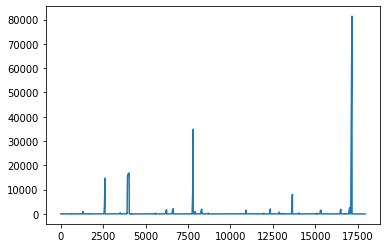

In [8]:
data.n_cases_weighted.plot()

In [9]:
model_data = data.iloc[:, 1:]
start_date = 64
window_size = 32
n_days_into_future = 1
# can't include the max date because need at least 1 day in future to predict. +1 because of how range doesn't include endpoint
for max_date_in_window in range(start_date, model_data.date_proxy.max() - n_days_into_future + 1):
 
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    windowed_data = model_data[model_data.date_proxy <= max_date_in_window]
    #     print(windowed_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_windowed_data = windowed_data.values.reshape(n_countries, max_date_in_window, -1)
    #     print(reshaped_windowed_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    resized_window_data = pad_sequences(reshaped_windowed_data, maxlen=window_size)
    
    window_data_4d = resized_window_data[np.newaxis, :, :, :]

    #     print(resized_window_data.shape)
    #
    future_index = model_data[model_data.date_proxy == max_date_in_window].index
    n_step_predictions = target_data.loc[future_index, n_days_into_future]
    if max_date_in_window == start_date:
        X = window_data_4d.copy()
        y = n_step_predictions.values.reshape(1,-1)
    else:
        X = np.concatenate((X, window_data_4d),axis=0)
        y = np.concatenate((y, n_step_predictions.values.reshape(1,-1)),axis=0)
print(X.shape)
n_windows, n_countries, n_time_steps, n_features = X.shape
print(y.shape)

(66, 138, 32, 152)
(66, 138)


In [10]:
# alternative method of slicing target values
#     future_index = model_data[model_data.date_proxy == leading_window_date_included + n_days_into_future].index
#     n_step_predictions = model_data.loc[future_index, 'n_cases_weighted']

Now, splitting X intro train, validate, test, is as easy as slicing the first axis. Depending on how the CNN is set up, this
axis can later be flattened by simply applying ```np.concatenate(X_train, axis=0)```

Now, for the target data ```y```. To be as general as possible, I note that I should first shift the time series and combine them to store all of the data, and THEN manipulate it, i.e.

Assuming that ```X``` is of the shape ```(n_windows, n_countries, n_time_steps, n_features)```, the target data ```y``` should
be of shape ```(n_windows, n_countries)``` and the values for each slice of the first axis is then of shape ```(n_countries,)```, with the values equaling the ```model_data.n_cases_weighted``` value for ```date_proxy == window_right_edge_inclusive + n```, where n is the prediction step size. 

Because we need future values with which to measure error, the maximum that the leading window edge can be is always 

```model_data.date_proxy.max() - n```

In other words, because the maximum date value is

In [11]:
model_data.date_proxy.max()

130

If I want to predict (and measure error) for 7 days in the future, the last window would have leading edge 
```model_data.date_proxy == 123```. 

For now, just test the waters with a 1-day prediction.
To do so, first split the X and y data into train, validate, test.
For the first attempt at a model, use Conv1D only, have to flatten the data with concatenations.
Before this, however, I want to rescale the data. Now, because each different element in the first axis is a different time range, the correct action is to (if normalizing) take the mean with respect to axis=1 and axis=2 ```n_countries``` and  ```n_time_steps```. This leaves a total number of averages of shape ```(n_windows, n_features)```, i.e. the mean and standard deviations for each feature for each date range. This ensures that no data snooping has occurred. To actually subtract and divide by these values, need to reform the same shape array (or at least that seems to be the easiest method to me.

In [12]:
X_train, y_train = np.concatenate(X[:-7,:,:,:],axis=0), np.concatenate(y[:-7,:],axis=0)

The normalization approach I'm using doesn't utilize all values in the history to normalize; only values in the specific windows

In [ ]:
Xmean = np.tile(X[:-7,:,:,:].std(axis=(1,2))[:, np.newaxis, np.newaxis, :], (1, n_countries, n_time_steps, 1))

Just to check, the slice [0, :, :, 0] should only contain one value.

In [14]:
pd.Series(Xmean[0,:,:,0].ravel()).value_counts()

9.233093    4416
dtype: int64

In [15]:
def normalize(X):
    X_means = np.tile(X.mean(axis=(1,2))[:, np.newaxis, np.newaxis, :], (1, n_countries, n_time_steps, 1))
    X_stds = np.tile(X.std(axis=(1,2))[:, np.newaxis, np.newaxis, :], (1, n_countries, n_time_steps, 1))
    return (X - X_means) / X_stds

In [16]:
X_train, y_train = X[:-7,:,:,:], y[:-7,:]

In [17]:
X_training_means = np.tile(X_train.mean(axis=(1,2))[:, np.newaxis, np.newaxis, :], (1, n_countries, n_time_steps, 1))
X_training_stds = np.tile(X_train.std(axis=(1,2))[:, np.newaxis, np.newaxis, :], (1, n_countries, n_time_steps, 1))

In [27]:
X_train = np.concatenate((X_train - X_training_means) / X_training_stds,axis=0)

In [19]:
X_mean = X_train.mean(axis=(1,2))[-1,:][np.newaxis, np.newaxis, np.newaxis, :]
X_std = X_train.std(axis=(1,2))[-1,:][np.newaxis, np.newaxis, np.newaxis, :]

In [20]:
X_validate, y_validate = X[-7:-4,:,:,:], y[-7:-4,:]
X_test, y_test = X[-4:,:,:,:], y[-4:,:]

In [28]:
X_validate = np.concatenate(((X_validate - np.tile(X_mean, (X_validate.shape[0],X_validate.shape[1],X_validate.shape[2],1)))
                / np.tile(X_std, (X_validate.shape[0],X_validate.shape[1],X_validate.shape[2],1))),axis=0)

In [29]:
X_test = np.concatenate(((X_test - np.tile(X_mean, (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))) 
            / np.tile(X_std, (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))),axis=0)

In [30]:
y_train, y_validate, y_test = np.concatenate(y_train, axis=0),np.concatenate(y_validate, axis=0),np.concatenate(y_test, axis=0)

In [31]:
# X_validate, y_validate = np.concatenate(normalize(X[-7:-4,:,:,:]), axis=0), np.concatenate(y[-7:-4,:],axis=0)
# X_test, y_test = np.concatenate(normalize(X[-4:,:,:,:]), axis=0), np.concatenate(y[-4:,:],axis=0)

In [32]:
# X_train, y_train = np.concatenate(normalize(X[:-7,:,:,:]), axis=0), np.concatenate(y[:-7,:],axis=0)
# X_validate, y_validate = np.concatenate(normalize(X[-7:-4,:,:,:]), axis=0), np.concatenate(y[-7:-4,:],axis=0)
# X_test, y_test = np.concatenate(normalize(X[-4:,:,:,:]), axis=0), np.concatenate(y[-4:,:],axis=0)

In [33]:
epochs, batch_size = 25, 256
#     n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=X_train.shape[1:]))
# model.add(Conv1D(filters=8, kernel_size=16, activation='relu'))
# model.add(Dropout(0.5))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
model.fit(X_train, y_train, epochs=10, validation_data=(X_validate, y_validate), batch_size=256)
# evaluate model
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
#     return accuracy

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


Train on 8142 samples, validate on 414 samples
Epoch 1/10
8142/8142 [==============================] - 1s 125us/sample - loss: 582.6169 - val_loss: 34617250.1546
Epoch 2/10
8142/8142 [==============================] - 1s 107us/sample - loss: 581.6158 - val_loss: 65273568.7343
Epoch 3/10
8142/8142 [==============================] - 1s 109us/sample - loss: 580.3932 - val_loss: 115856711.8068
Epoch 4/10
8142/8142 [==============================] - 1s 109us/sample - loss: 578.2898 - val_loss: 166047052.1353
Epoch 5/10
8142/8142 [==============================] - 1s 110us/sample - loss: 576.4662 - val_loss: 205057879.7681
Epoch 6/10
8142/8142 [==============================] - 1s 108us/sample - loss: 573.1527 - val_loss: 247018436.4831
Epoch 7/10
8142/8142 [==============================] - 1s 108us/sample - loss: 570.4393 - val_loss: 203795531.6715
Epoch 8/10
8142/8142 [==============================] - 1s 108us/sample - loss: 567.4760 - val_loss: 184871249.8551
Epoch 9/10
8142/8142 [=====

114438263.88405797

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
ymin, ymax = np.min([y_test.min(), y_predict.min()]), np.max([y_test.max(), y_predict.max()])
plt.scatter(y_test, y_predict)
plt.plot([0,ymax], [0,ymax])
plt.ylabel('Predicted value')
plt.xlabel('True value')


In [ ]:
X_train, y_train = X[:-7,:,:,:], y[:-7,:]
X_validate, y_validate = X[-7:-4,:,:,:], y[-7:-4,:]
X_test, y_test = X[-4:,:,:,:], y[-4:,:]

In [ ]:
epochs, batch_size = 0, 10, 256
#     n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(SeparableConv2D(filters=128, kernel_size=3, data_format='channels_first', activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='mae', optimizer='adam')
# fit network
model.fit(trainX, trainy, epochs=epochs, validation_data=(X_validate, y_validate), batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#     return accuracy

In [ ]:
# fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


In [ ]:
verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
return accuracy